In [1]:
from utils import *
# load RoNIN data
data = load_data(verbose=True)

CONTENTS OF HDF5 FILE:
pose
	 ekf_ori, tango_ori, tango_pos
raw
	 imu
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, wifi_address, wifi_values
	 tango
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, tango_adf_pose, tango_pose, wifi_address, wifi_values
synced
	 acce, game_rv, grav, gyro, gyro_uncalib, linacce, magnet, rv, time


In [142]:
y_full_length = np.hstack((data['pose/tango_pos'], data['pose/tango_ori'],))
X_full_length = np.hstack((data['synced/acce'], data['synced/gyro'], data['synced/magnet']))

y_batches = np.array_split(y_full_length, 100)
X_batches = np.array_split(X_full_length, 100)

print(y_full_length.shape)
print(X_full_length.shape)

# set the start of every X to 0
X_batches = [X - X[0] for X in X_batches]

# set the start of every y to 0
y_batches = [y - y[0] for y in y_batches]

# make sure all batches are the same length
X_batches = [X[:len(X_batches[0])-1] for X in X_batches]
y_batches = [y[:len(y_batches[0])-1] for y in y_batches]

# make into numpy arrays
X_batches = np.array(X_batches)
y_batches = np.array(y_batches)


(67610, 7)
(67610, 9)


In [143]:
X_batches_flat = np.reshape(X_batches, (X_batches.shape[0], -1))
y_batches_flat = np.reshape(y_batches, (y_batches.shape[0], -1))
# shapes
print(X_batches_flat.shape)
print(y_batches_flat.shape)

X_batches_flat = X_batches_flat[:10]
y_batches_flat = y_batches_flat[:10]


(100, 6084)
(100, 4732)


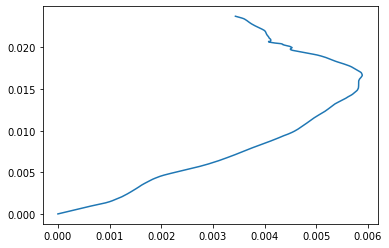

In [144]:
plt.plot(y_batches_flat[0].reshape(-1, 7)[:,0], y_batches_flat[0].reshape(-1, 7)[:,1])


In [164]:
# define NN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
        
        def __init__(self, input_size, hidden_size, output_size):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size, ) 
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc21 = nn.Linear(hidden_size, hidden_size)
            self.fc22 = nn.Linear(hidden_size, hidden_size)
            self.fc23 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, output_size)
        
        def forward(self, x):
            x = F.relu(self.fc1(x)) 
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = self.fc3(x)
            return x
        
net = Net(X_batches_flat.shape[1], 1000, y_batches_flat.shape[1])
# print number of params
print(sum(p.numel() for p in net.parameters() if p.requires_grad))

14825732


In [165]:
# turn into torch tensor
X_batches_flat = torch.from_numpy(X_batches_flat).float()
y_batches_flat = torch.from_numpy(y_batches_flat).float()


TypeError: expected np.ndarray (got Tensor)

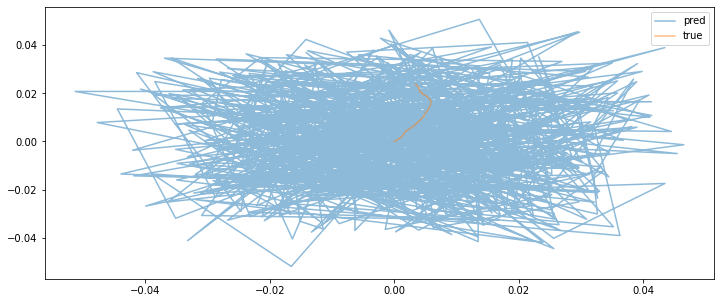

In [166]:
pred = net(X_batches_flat)
pred.shape, y_batches_flat.shape

# plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 5))


ax.plot(pred[0].detach().numpy().reshape(-1, 7)[:,0], pred[0].detach().numpy().reshape(-1, 7)[:,1], alpha=0.5, label='pred')
ax.plot(y_batches_flat[0].reshape(-1, 7)[:,0], y_batches_flat[0].reshape(-1, 7)[:,1], alpha=0.5, label='true')
ax.legend()


In [170]:
# Loss function
def loss(y_true, y_pred):
    """
    Loss function which penalizes the difference between the predicted and true. The initial orientation and velocity may be wrong, so we should compensate for this
    """
    pred = y_pred.reshape(-1, 7)[:,:3]
    true = y_true.reshape(-1, 7)[:,:3]

    # try rotation to align
    def rot_2_min(R_flat):
        R = R_flat.reshape(3, 3)
        # rotate pred by R
        rotated = R @ pred.detach().numpy().T
        rotated = torch.from_numpy(rotated.T).float()
        #print(rotated.shape, true.shape)
        return np.sum(np.linalg.norm(rotated - true, axis=1))

    # try all rotations
    from scipy.optimize import minimize
    #print('before', np.sum(np.linalg.norm(pred.detach().numpy() - true.detach().numpy(), axis=1)))
    res = minimize(rot_2_min, np.random.rand(9), method='Nelder-Mead')
    after = rot_2_min(res.x)
    #print('after', after)
    return torch.tensor(after, requires_grad=True)
# Optimizer
optimizer = optim.Adam(net.parameters(), lr=0.1)

# Train
losses=[]
for epoch in range(20):  # loop over the dataset multiple times
    loss_accum = 0
    for i, (X_, y_) in enumerate(zip(X_batches_flat, y_batches_flat)):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(X_)
        loss_value = loss(y_, outputs)
        loss_value.backward()
        optimizer.step()
        loss_accum += loss_value.item()
        
        
        if i % 9 == 0:
            print('EPOCH:', epoch, 'BATCH:', i, 'LOSS:', loss_value.item())
    losses.append(loss_accum)

EPOCH: 0 BATCH: 0 LOSS: 10.42989730834961
EPOCH: 1 BATCH: 0 LOSS: 10.430713653564453
EPOCH: 2 BATCH: 0 LOSS: 10.429899215698242
EPOCH: 3 BATCH: 0 LOSS: 10.443164825439453
EPOCH: 4 BATCH: 0 LOSS: 10.485389709472656
EPOCH: 5 BATCH: 0 LOSS: 10.443761825561523
EPOCH: 6 BATCH: 0 LOSS: 10.48760986328125
EPOCH: 7 BATCH: 0 LOSS: 10.429939270019531
EPOCH: 8 BATCH: 0 LOSS: 10.429998397827148
EPOCH: 9 BATCH: 0 LOSS: 10.429899215698242
EPOCH: 10 BATCH: 0 LOSS: 10.429899215698242
EPOCH: 11 BATCH: 0 LOSS: 10.429899215698242
EPOCH: 12 BATCH: 0 LOSS: 10.531193733215332
EPOCH: 13 BATCH: 0 LOSS: 10.429910659790039
EPOCH: 14 BATCH: 0 LOSS: 10.429901123046875
EPOCH: 15 BATCH: 0 LOSS: 10.42989730834961
EPOCH: 16 BATCH: 0 LOSS: 10.429899215698242
EPOCH: 17 BATCH: 0 LOSS: 10.429899215698242
EPOCH: 18 BATCH: 0 LOSS: 10.464754104614258
EPOCH: 19 BATCH: 0 LOSS: 10.42989730834961


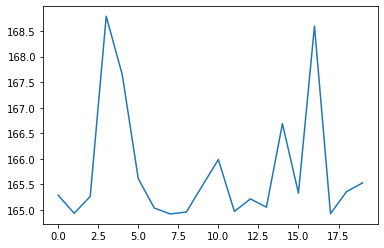

In [171]:
# plot losses
plt.plot(losses)

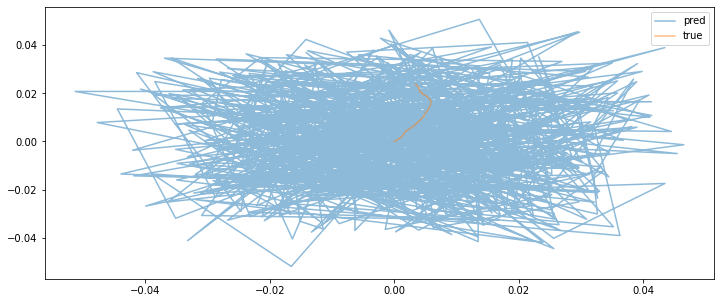

In [172]:
pred = net(X_batches_flat)
pred.shape, y_batches_flat.shape

# plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 5))


ax.plot(pred[0].detach().numpy().reshape(-1, 7)[:,0], pred[0].detach().numpy().reshape(-1, 7)[:,1], alpha=0.5, label='pred')
ax.plot(y_batches_flat[0].reshape(-1, 7)[:,0], y_batches_flat[0].reshape(-1, 7)[:,1], alpha=0.5, label='true')
ax.legend()
